In [1]:
from pathlib import Path
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DB_PATH = PROJECT_ROOT / "data" / "processed" / "vbb_gtfs.db"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

DB_PATH


WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/vbb_gtfs.db')

In [2]:
conn = sqlite3.connect(DB_PATH)

sql_activity = """
SELECT
    s.stop_id,
    s.stop_name,
    s.stop_lat,
    s.stop_lon,
    COUNT(*) AS n_arrivals
FROM stop_times st
JOIN stops s ON st.stop_id = s.stop_id
GROUP BY
    s.stop_id,
    s.stop_name,
    s.stop_lat,
    s.stop_lon
"""

stop_activity = pd.read_sql_query(sql_activity, conn)
stop_activity.head()


,stop_id,stop_name,stop_lat,stop_lon,n_arrivals
0,000000104497,"Forsthaus, Grabow (Meckl)",53.283943,11.556491,38
1,000000104782,"Ludwigslust, Am Bahnhof",53.334086,11.494929,119
2,000000109220,"Schwerin, Bahnhof Süd",53.575076,11.375881,18
3,000000111918,"Stendal, Hauptbahnhof (Bus)",52.595340,11.856250,5
4,000000204231,"Wabeler Str., Neustadt-Glewe",53.378380,11.591790,36


In [3]:
# delays is per trip+stop; aggregate by stop_id
sql_delays = """
SELECT
    d.stop_id,
    COUNT(*) AS n_delay_events,
    AVG(d.delay_min) AS avg_delay_min,
    SUM(CASE WHEN d.delay_min > 5 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_over_5min,
    SUM(CASE WHEN d.delay_min <= 0 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS share_on_time_or_early
FROM delays d
GROUP BY d.stop_id
"""

stop_delays = pd.read_sql_query(sql_delays, conn)
conn.close()

stop_delays.head()


,stop_id,n_delay_events,avg_delay_min,share_over_5min,share_on_time_or_early
0,000000306276,1,-1.0,0.0,1.0
1,000000404511,1,-2.0,0.0,1.0
2,000000406424,1,3.0,0.0,0.0
3,000000705240,1,1.0,0.0,0.0
4,000005100145,1,0.0,0.0,1.0


In [4]:
stops = pd.merge(stop_activity, stop_delays, on="stop_id", how="left")

# Fill missing delay stats with zeros for stops without delay events
for col in ["n_delay_events", "avg_delay_min", "share_over_5min", "share_on_time_or_early"]:
    if col in stops.columns:
        stops[col] = stops[col].fillna(0)

# Define a hotspot score:
# - more arrivals = more important
# - more delay events = more problematic
# - higher avg delay (positive only) = worse
stops["impact_score"] = (
    stops["n_arrivals"] * (stops["avg_delay_min"].clip(lower=0)) * (stops["n_delay_events"].clip(lower=1))
)

stops["norm_impact"] = stops["impact_score"] / (stops["impact_score"].max() or 1)
stops["norm_arrivals"] = stops["n_arrivals"] / (stops["n_arrivals"].max() or 1)

stops["hotspot_score"] = 0.7 * stops["norm_impact"] + 0.3 * stops["norm_arrivals"]

stops_sorted = stops.sort_values("hotspot_score", ascending=False).reset_index(drop=True)
stops_sorted.head(10)


,stop_id,stop_name,stop_lat,stop_lon,n_arrivals,n_delay_events,avg_delay_min,share_over_5min,share_on_time_or_early,impact_score,norm_impact,norm_arrivals,hotspot_score
0,de:11000:900004181::3,Hertzallee (Berlin),52.509228,13.332082,5934,14.0,2.071429,0.214286,0.571429,172086.0,1.000000,1.000000,1.000000
1,de:11000:900029202::1,"Berlin, Moritzstr.",52.539015,13.200849,3638,9.0,4.111111,0.222222,0.444444,134606.0,0.782202,0.613077,0.731465
2,de:11000:900029302::4,S+U Rathaus Spandau (Berlin),52.535942,13.199838,3473,10.0,3.700000,0.100000,0.300000,128501.0,0.746725,0.585271,0.698289
3,de:11000:900023302::4,U Adenauerplatz (Berlin),52.499997,13.308223,2561,11.0,4.545455,0.181818,0.181818,128050.0,0.744105,0.431581,0.650348
4,de:11000:900044101:1:50,S Hohenzollerndamm (Berlin),52.488671,13.300271,3123,19.0,2.000000,0.052632,0.315789,118674.0,0.689620,0.526289,0.640621
5,de:11000:900024203:1:51,S Savignyplatz (Berlin),52.505117,13.319066,4257,18.0,1.333333,0.111111,0.555556,102168.0,0.593703,0.717391,0.630810
6,de:11000:900023201::5,S+U Zoologischer Garten Bhf (Berlin),52.506741,13.333567,5672,20.0,0.700000,0.050000,0.500000,79408.0,0.461444,0.955848,0.609765
7,de:11000:900023203::9,U Kurfürstendamm (Berlin),52.503694,13.330197,2743,9.0,4.444444,0.222222,0.333333,109720.0,0.637588,0.462251,0.584987
8,de:11000:900029201::1,"Berlin, Wröhmännerpark",52.542030,13.205646,2631,12.0,3.083333,0.166667,0.250000,97347.0,0.565688,0.443377,0.528995
9,de:11000:900031101::3,"Berlin, Brunsbütteler Damm/Ruhlebener Str.",52.532180,13.197531,2506,11.0,3.545455,0.181818,0.454545,97734.0,0.567937,0.422312,0.524250


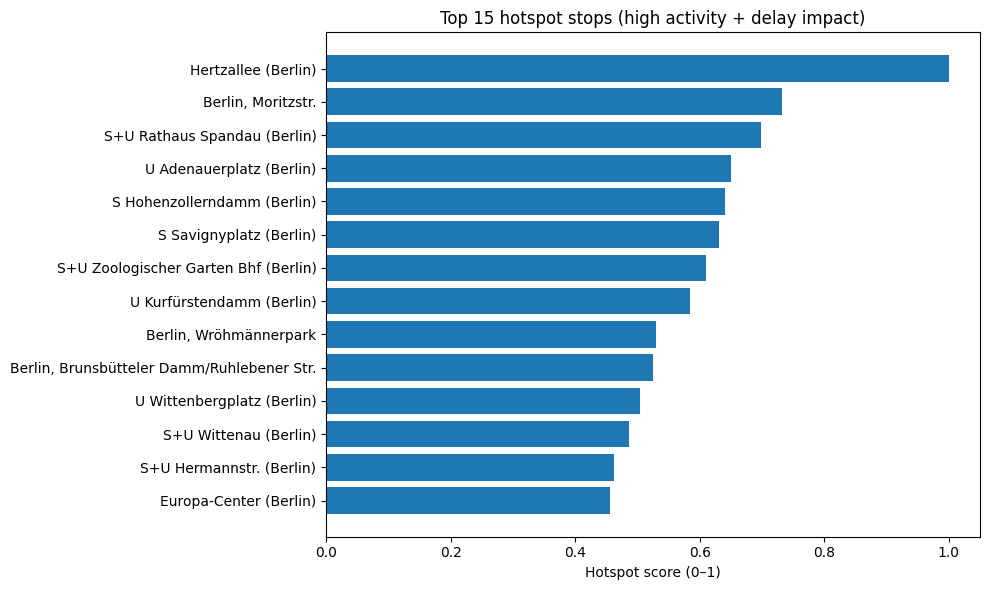

,stop_id,stop_name,n_arrivals,n_delay_events,avg_delay_min,share_over_5min,impact_score,hotspot_score
0,de:11000:900004181::3,Hertzallee (Berlin),5934,14.0,2.071429,0.214286,172086.0,1.000000
1,de:11000:900029202::1,"Berlin, Moritzstr.",3638,9.0,4.111111,0.222222,134606.0,0.731465
2,de:11000:900029302::4,S+U Rathaus Spandau (Berlin),3473,10.0,3.700000,0.100000,128501.0,0.698289
3,de:11000:900023302::4,U Adenauerplatz (Berlin),2561,11.0,4.545455,0.181818,128050.0,0.650348
4,de:11000:900044101:1:50,S Hohenzollerndamm (Berlin),3123,19.0,2.000000,0.052632,118674.0,0.640621
5,de:11000:900024203:1:51,S Savignyplatz (Berlin),4257,18.0,1.333333,0.111111,102168.0,0.630810
6,de:11000:900023201::5,S+U Zoologischer Garten Bhf (Berlin),5672,20.0,0.700000,0.050000,79408.0,0.609765
7,de:11000:900023203::9,U Kurfürstendamm (Berlin),2743,9.0,4.444444,0.222222,109720.0,0.584987
8,de:11000:900029201::1,"Berlin, Wröhmännerpark",2631,12.0,3.083333,0.166667,97347.0,0.528995
9,de:11000:900031101::3,"Berlin, Brunsbütteler Damm/Ruhlebener Str.",2506,11.0,3.545455,0.181818,97734.0,0.524250


In [5]:
top_n = 15
top_hotspots = stops_sorted.head(top_n)

plt.figure(figsize=(10, 6))
labels = top_hotspots["stop_name"]
plt.barh(labels, top_hotspots["hotspot_score"])
plt.gca().invert_yaxis()
plt.xlabel("Hotspot score (0–1)")
plt.title(f"Top {top_n} hotspot stops (high activity + delay impact)")
plt.tight_layout()
plt.show()

top_hotspots[[
    "stop_id",
    "stop_name",
    "n_arrivals",
    "n_delay_events",
    "avg_delay_min",
    "share_over_5min",
    "impact_score",
    "hotspot_score",
]]


In [6]:
output_path = DATA_PROCESSED / "stop_hotspot_kpis.csv"
stops_sorted.to_csv(output_path, index=False)
output_path


WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/stop_hotspot_kpis.csv')